In [261]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
import yfinance as yf
import os 
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

In [265]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
esg_risk_score = [23.6, 38.3, 14.2, 13.2, 13.4, 19.5, 25.3]
e_risk_score = [1.5, 0, 1.6, 2.4, 4.7, 0, 5.9]
s_risk_score = [11.5, 0, 7.6, 4.7, 4.6, 0, 12.4]
g_risk_score = [10.6, 0, 5.0, 6.0, 4.2, 0, 7.1]

sustain_data = pd.DataFrame({
    'Ticker': tickers,
    'ESG Risk Score': esg_risk_score,
    'Environmental Risk Score': e_risk_score,
    'Social Risk Score': s_risk_score,
    'Governance Risk Score': g_risk_score
})


In [266]:
def get_data(tickers):
    data = yf.download(tickers, start="2023-01-01", end="2024-10-17")['Adj Close']
    return data

In [267]:
hist_data = get_data(tickers)
log_returns = np.log(hist_data / hist_data.shift(1)).dropna()
hist_data.head()

[*********************100%%**********************]  7 of 7 completed


,CB,CELH,MSFT,NVDA,QCOM,SMCI,WMT
Date,,,,,,,
2023-01-03,214.920654,33.490002,236.183517,14.305580,102.922829,8.386,46.692333
2023-01-04,218.454453,33.636665,225.852112,14.739295,107.080078,8.225,46.744354
2023-01-05,217.636719,33.743332,219.158340,14.255614,105.035049,8.025,46.585033
2023-01-06,222.796310,32.419998,221.741180,14.849223,110.738052,8.439,47.726326
2023-01-09,217.588058,32.556667,223.900177,15.617718,110.037178,8.477,47.131287


In [268]:
log_returns.head()

,CB,CELH,MSFT,NVDA,QCOM,SMCI,WMT
Date,,,,,,,
2023-01-04,0.016309,0.004370,-0.044729,0.029867,0.039597,-0.019385,0.001114
2023-01-05,-0.003750,0.003166,-0.030086,-0.033366,-0.019283,-0.024617,-0.003414
2023-01-06,0.023431,-0.040007,0.011716,0.040797,0.052873,0.050302,0.024204
2023-01-09,-0.023654,0.004207,0.009689,0.050458,-0.006349,0.004493,-0.012546
2023-01-10,0.005622,0.035899,0.007588,0.017821,0.019869,-0.078501,-0.000621


In [269]:
def covariance_matrix(log_rets):
    x = (log_rets).cov()*252
    return x.values

In [270]:
def compute_metrics(log_rets, tickers):
    means = []
    vols = []
    
    # Calculate the mean and volatility (standard deviation) for each ticker
    for i in tickers:
        mean = log_rets[i].mean()*252
        vol = log_rets[i].std()*np.sqrt(252)
        means.append(mean)
        vols.append(vol)
    
    # Create a DataFrame to hold the metrics
    metrics_df = pd.DataFrame({
        'Annualized Mean': means,
        'Annualized Volatility': vols
    }, index=tickers)
    
    return metrics_df

In [271]:
expected_returns = compute_metrics(log_returns, tickers)["Annualized Mean"].values
stock_vols = compute_metrics(log_returns, tickers)["Annualized Volatility"].values

In [272]:
cov_mat = covariance_matrix(log_returns)
cov_mat

array([[ 3.68819872e-02,  9.12177349e-03, -8.56199547e-04,
        -5.99295351e-03,  2.93686129e-03, -3.78997432e-03,
         6.26314674e-03],
       [ 9.12177349e-03,  3.30399998e-01,  2.92401978e-02,
         5.62159958e-02,  3.36035609e-02,  5.86371062e-02,
         1.11592515e-02],
       [-8.56199547e-04,  2.92401978e-02,  5.13858185e-02,
         5.79791495e-02,  3.00268406e-02,  5.64668685e-02,
         4.73118659e-03],
       [-5.99295351e-03,  5.62159958e-02,  5.79791495e-02,
         2.58134666e-01,  9.83431715e-02,  2.35294468e-01,
         3.90793095e-04],
       [ 2.93686129e-03,  3.36035609e-02,  3.00268406e-02,
         9.83431715e-02,  1.25135799e-01,  9.84770918e-02,
         3.02784072e-03],
       [-3.78997432e-03,  5.86371062e-02,  5.64668685e-02,
         2.35294468e-01,  9.84770918e-02,  7.84441398e-01,
         6.03457102e-03],
       [ 6.26314674e-03,  1.11592515e-02,  4.73118659e-03,
         3.90793095e-04,  3.02784072e-03,  6.03457102e-03,
         2.7612429

In [273]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def optimize_portfolio_long_only(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def optimize_portfolio_with_short(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between -1 and 2 (no overleverage)
    bounds = tuple((-1, 2) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [274]:
target_return = 0.08
optimized_result = optimize_portfolio_long_only(cov_mat, expected_returns, target_return)

print("Optimal Weights:", optimized_result.x)
print("Minimized Portfolio Variance:", optimized_result.fun)

Optimal Weights: [4.43990462e-01 5.56009538e-01 2.84494650e-16 5.55111512e-17
 4.16333634e-17 0.00000000e+00 4.85722573e-17]
Minimized Portfolio Variance: 0.11391614860798922


In [275]:
target_returns = np.arange(0,1.1,.0005)
port_rets_lo = []
port_vols_lo = []
for tar_ret in target_returns:
    optimized_result = optimize_portfolio_long_only(cov_mat, expected_returns, tar_ret)
    port_return = tar_ret
    port_vol = np.sqrt(optimized_result.fun)
    port_rets_lo.append(port_return)
    port_vols_lo.append(port_vol)

In [276]:
compute_metrics(log_returns, tickers)

,Annualized Mean,Annualized Volatility
CB,0.174124,0.192047
CELH,0.004839,0.574804
MSFT,0.317871,0.226684
NVDA,1.262775,0.508070
QCOM,0.286509,0.353745
SMCI,0.987875,0.885687
WMT,0.310696,0.166170


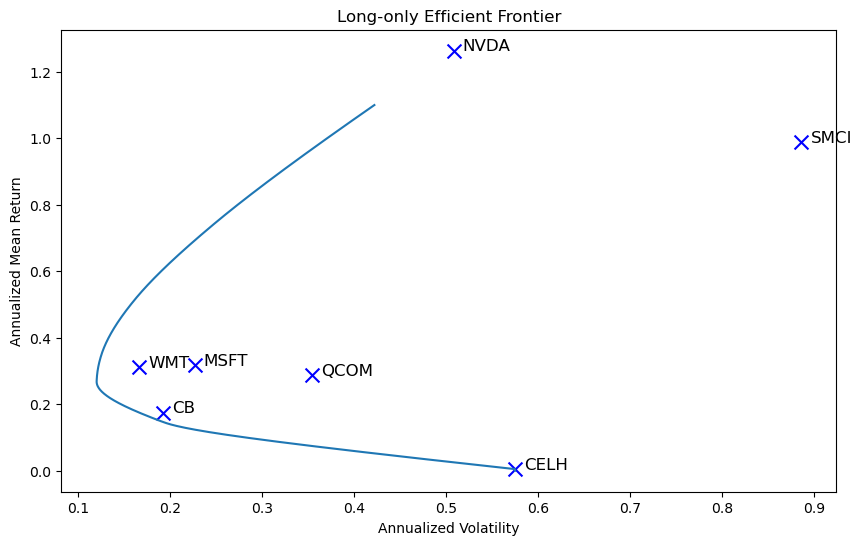

In [277]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, annualized_means, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, annualized_means[i], ticker, fontsize=12)
plt.plot(port_vols_lo, port_rets_lo,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Long-only Efficient Frontier')
plt.show()

In [278]:
target_returns = np.arange(-.5,2,.0005)
port_rets_s = []
port_vols_s = []
for tar_ret in target_returns:
    optimized_result = optimize_portfolio_with_short(cov_mat, expected_returns, tar_ret)
    port_return = tar_ret
    port_vol = np.sqrt(optimized_result.fun)
    port_rets_s.append(port_return)
    port_vols_s.append(port_vol)

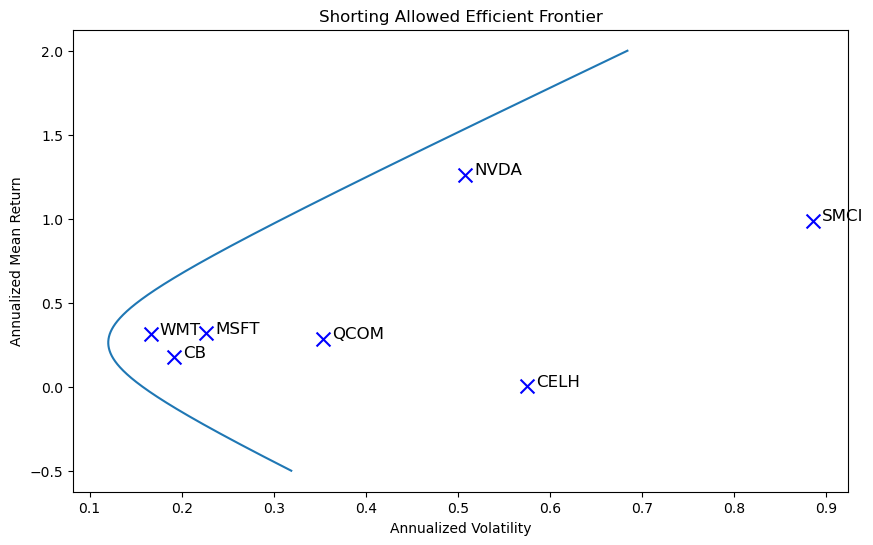

In [279]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, annualized_means, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, annualized_means[i], ticker, fontsize=12)
plt.plot(port_vols_s, port_rets_s,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Shorting Allowed Efficient Frontier')
plt.show()

In [280]:
def minvar_portfolio_long_only_ESG(cov_matrix, esg_risk_scores, esg_target):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        
        {'type': 'eq', 'fun': lambda weights: esg_target - np.dot(weights, esg_risk_scores)}  # Max ESG constraint
    )
    
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def minvar_portfolio_with_short_ESG(cov_matrix, esg_risk_scores, esg_target):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: esg_target - np.dot(weights, esg_risk_scores)}  #MAX ESG Constraint
    )
    
    # Bounds: Weights between -1 and 2 (no overleverage)
    bounds = tuple((-1, 2) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [281]:
esg_risk_score = [23.6, 38.3, 14.2, 13.2, 13.4, 19.5, 25.3]
esg_target = 15
esg_optimized_result = minvar_portfolio_long_only_ESG(cov_mat, esg_risk_score, esg_target)

print("Optimal Weights:", optimized_result.x)
print("Minimized Portfolio Variance:", optimized_result.fun)

Optimal Weights: [-0.05522222 -0.32764034 -0.68702606  1.6957714  -0.88665207 -0.07379623
  1.33456553]
Minimized Portfolio Variance: 0.4681997685915589


In [282]:
np.dot(optimized_result.x, annualized_means)

1.9995000000119463

In [283]:
esg_targets = np.arange(13.2,38.3,.05)
port_rets_esg_lo = []
port_vols_esg_lo = []
port_esgs_lo = []
for esg_tar in esg_targets:
    optimized_result = minvar_portfolio_long_only_ESG(cov_mat, esg_risk_score, esg_tar)
    port_esg = np.dot(optimized_result.x, esg_risk_score)
    port_return = np.dot(optimized_result.x, annualized_means)
    port_vol = np.sqrt(optimized_result.fun)
    port_rets_esg_lo.append(port_return)
    port_vols_esg_lo.append(port_vol)
    port_esgs_lo.append(port_esg)

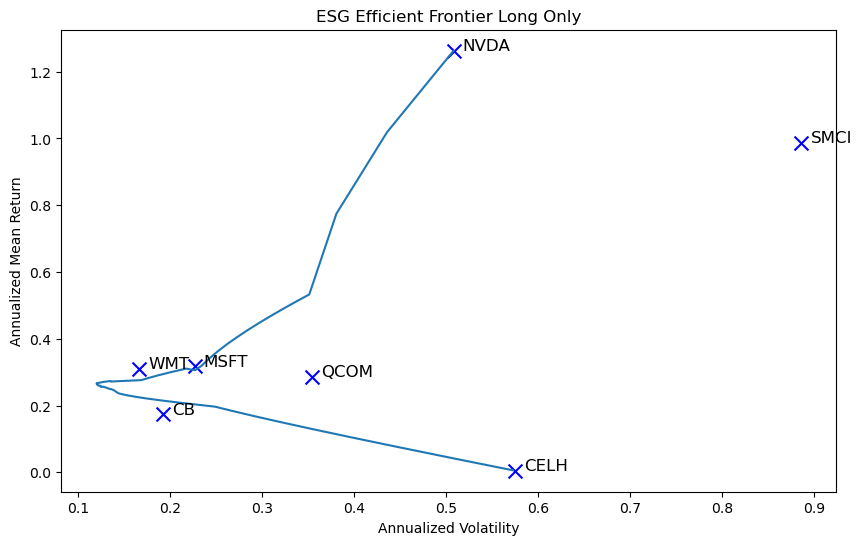

In [284]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, annualized_means, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, annualized_means[i], ticker, fontsize=12)
plt.plot(port_vols_esg_lo, port_rets_esg_lo,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('ESG Efficient Frontier Long Only')
plt.show()

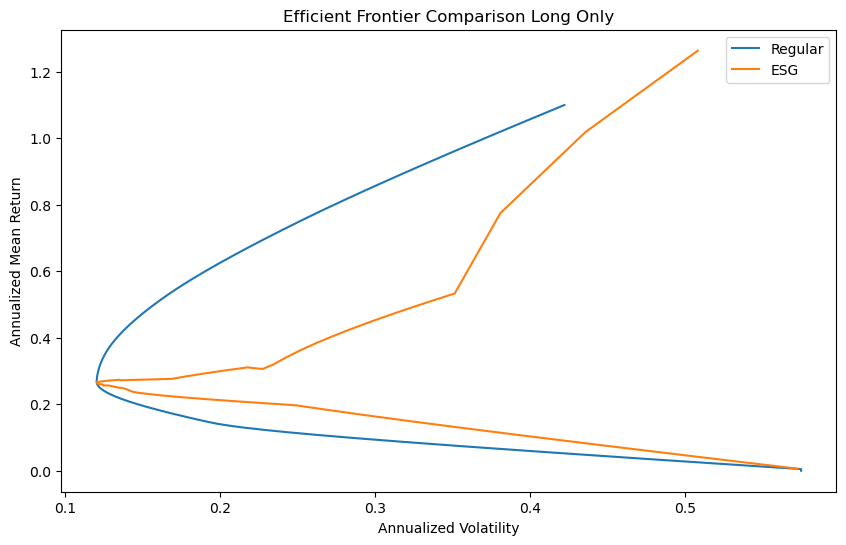

In [285]:
plt.figure(figsize=(10, 6))
plt.plot(port_vols_lo, port_rets_lo,label = 'Regular')
plt.plot(port_vols_esg_lo, port_rets_esg_lo,label = 'ESG')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Efficient Frontier Comparison Long Only')
plt.legend()
plt.show()

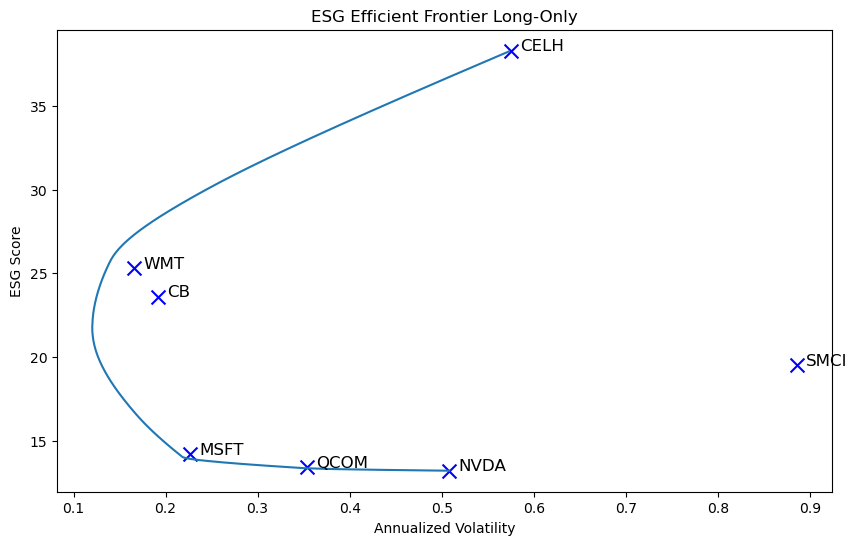

In [286]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, esg_risk_score, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, esg_risk_score[i], ticker, fontsize=12)
plt.plot(port_vols_esg_lo, port_esgs_lo,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('ESG Score')
plt.title('ESG Efficient Frontier Long-Only')
plt.show()

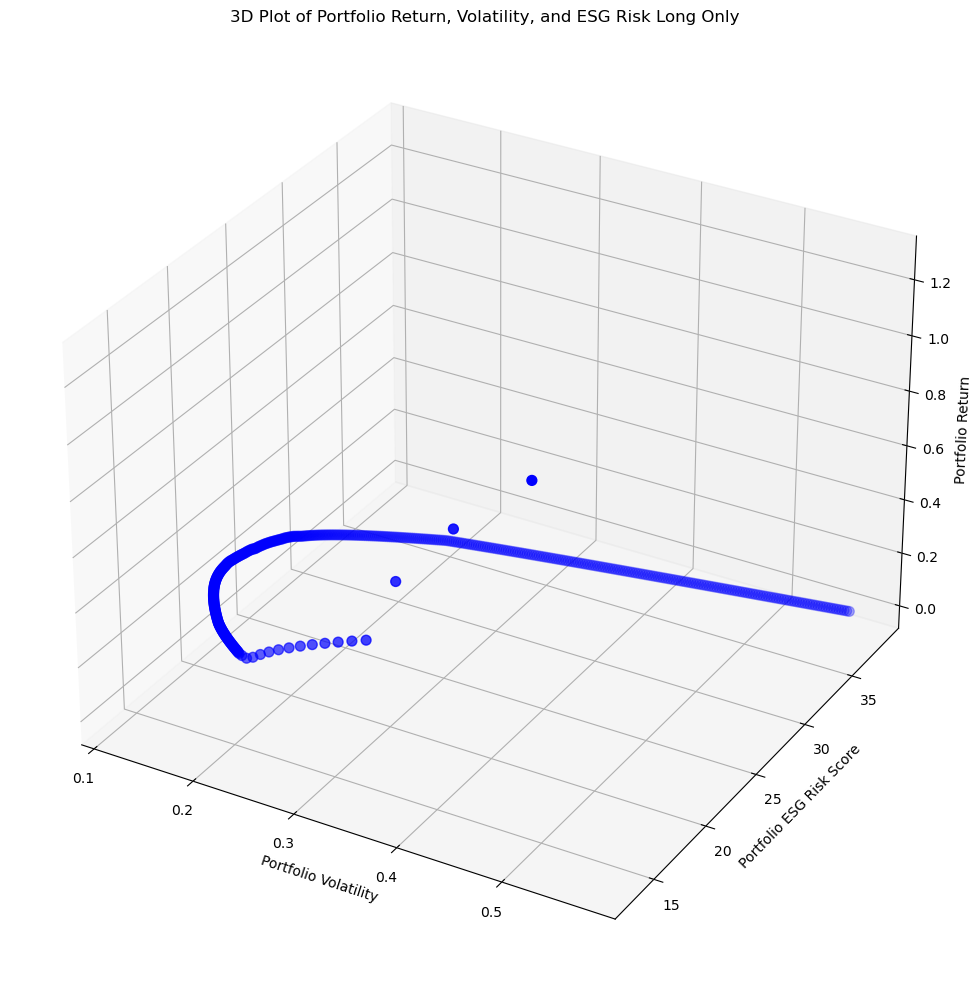

In [287]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(port_vols_esg_lo, port_esgs_lo, port_rets_esg_lo, color='blue', s=50)

ax.set_xlabel('Portfolio Volatility')
ax.set_zlabel('Portfolio Return')
ax.set_ylabel('Portfolio ESG Risk Score')

# Set title
ax.set_title('3D Plot of Portfolio Return, Volatility, and ESG Risk Long Only')
plt.tight_layout()
# Show the plot
plt.show()

In [288]:
esg_targets = np.arange(0,50,.05)
port_rets_esg_s = []
port_vols_esg_s = []
port_esgs_s = []
for esg_tar in esg_targets:
    optimized_result = minvar_portfolio_with_short_ESG(cov_mat, esg_risk_score, esg_tar)
    port_esg = np.dot(optimized_result.x, esg_risk_score)
    port_return = np.dot(optimized_result.x, annualized_means)
    port_vol = np.sqrt(optimized_result.fun)
    port_rets_esg_s.append(port_return)
    port_vols_esg_s.append(port_vol)
    port_esgs_s.append(port_esg)

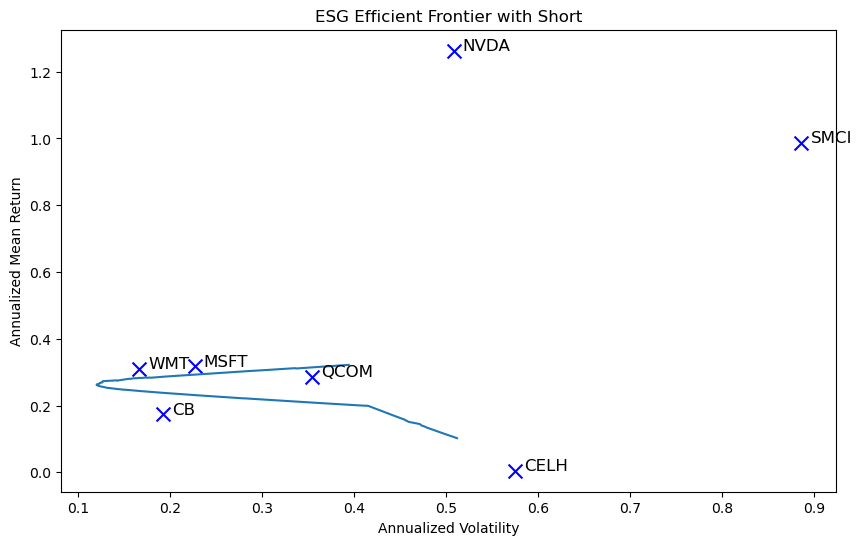

In [289]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, annualized_means, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, annualized_means[i], ticker, fontsize=12)
plt.plot(port_vols_esg_s, port_rets_esg_s,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('ESG Efficient Frontier with Short')
plt.show()

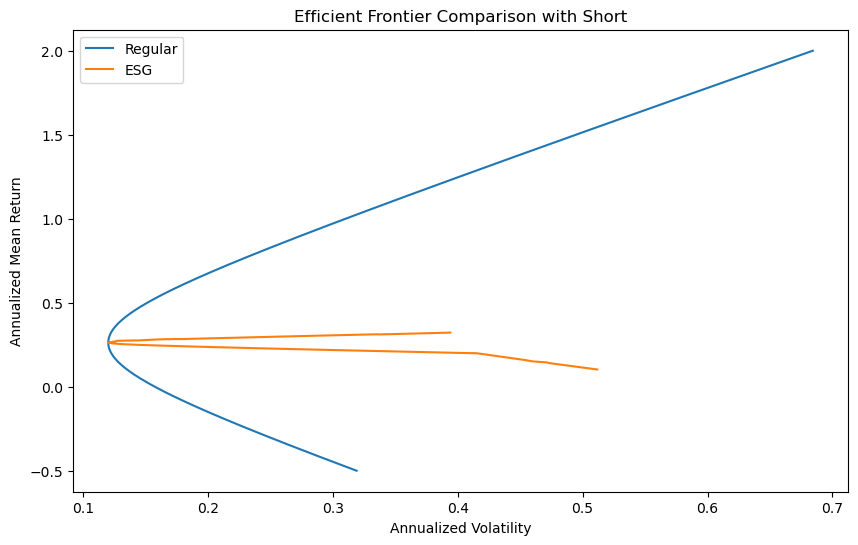

In [295]:
plt.figure(figsize=(10, 6))
plt.plot(port_vols_s, port_rets_s,label = 'Regular')
plt.plot(port_vols_esg_s, port_rets_esg_s,label = 'ESG')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Efficient Frontier Comparison with Short')
plt.legend()
plt.show()

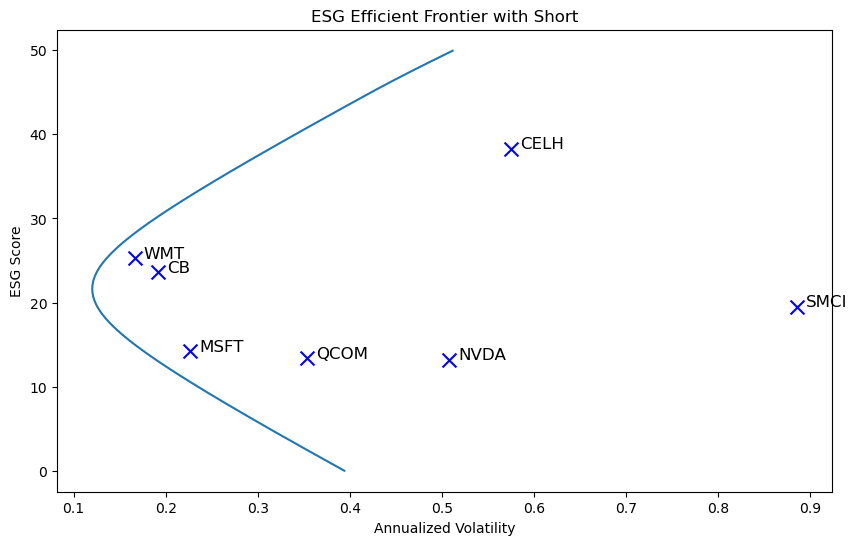

In [296]:
tickers = ['CB','CELH', 'MSFT', 'NVDA','QCOM','SMCI','WMT']
annualized_means = expected_returns
annualized_volatilities = stock_vols
plt.figure(figsize=(10, 6))
plt.scatter(annualized_volatilities, esg_risk_score, marker='x', color='blue', s=100)
for i, ticker in enumerate(tickers):
    plt.text(annualized_volatilities[i] + 0.01, esg_risk_score[i], ticker, fontsize=12)
plt.plot(port_vols_esg_s, port_esgs_s,label = 'Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('ESG Score')
plt.title('ESG Efficient Frontier with Short')
plt.show()

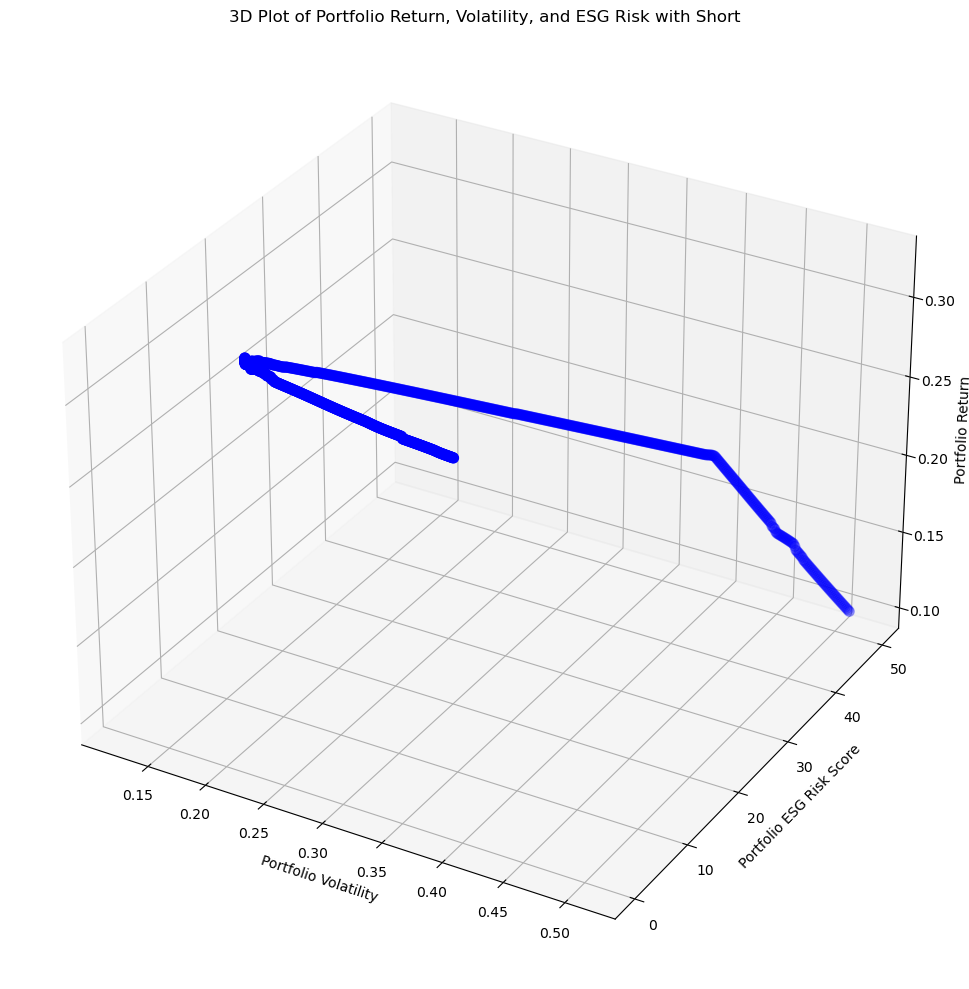

In [298]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(port_vols_esg_s, port_esgs_s, port_rets_esg_s, color='blue', s=50)

ax.set_xlabel('Portfolio Volatility')
ax.set_zlabel('Portfolio Return')
ax.set_ylabel('Portfolio ESG Risk Score')

# Set title
ax.set_title('3D Plot of Portfolio Return, Volatility, and ESG Risk with Short')
plt.tight_layout()
# Show the plot
plt.show()

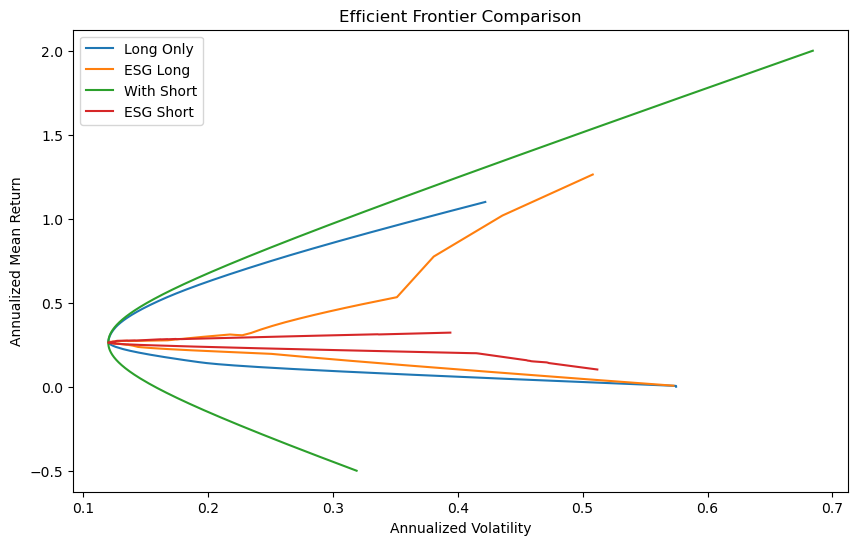

In [299]:
plt.figure(figsize=(10, 6))
plt.plot(port_vols_lo, port_rets_lo,label = 'Long Only')
plt.plot(port_vols_esg_lo, port_rets_esg_lo,label = 'ESG Long')
plt.plot(port_vols_s, port_rets_s,label = 'With Short')
plt.plot(port_vols_esg_s, port_rets_esg_s,label = 'ESG Short')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Efficient Frontier Comparison')
plt.legend()
plt.show()

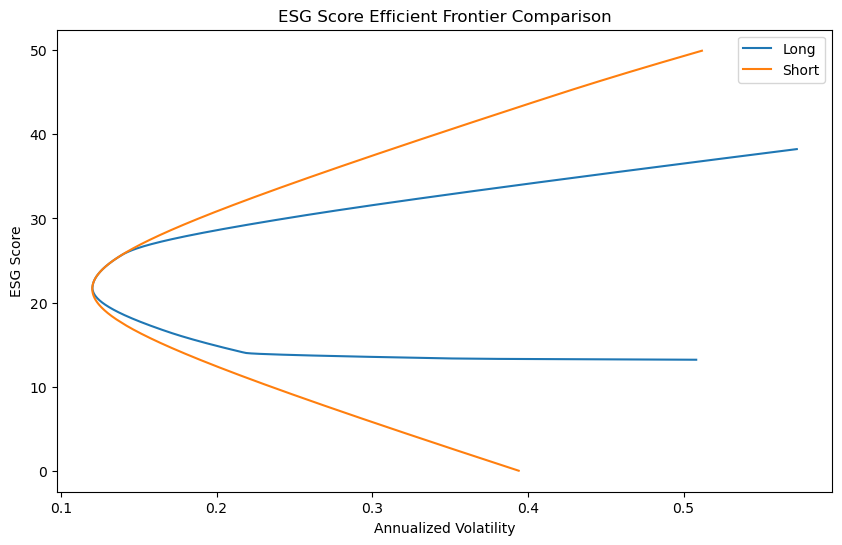

In [303]:
plt.figure(figsize=(10, 6))
plt.plot(port_vols_esg_lo, port_esgs_lo,label = 'Long')
plt.plot(port_vols_esg_s, port_esgs_s,label = 'Short')
plt.xlabel('Annualized Volatility')
plt.ylabel('ESG Score')
plt.title('ESG Score Efficient Frontier Comparison')
plt.legend()
plt.show()

In [302]:
'''Next look at 
1. adding return constraint to the ESG ones in addition
2. see if i can create a 3d surface for the esg, min var, return surface. Maybe need to enable unlimited shorting???
3. changing the objective function
4. expanding to a different dataset one that is more related as suspect there is difference in the esg scores because of the nature of the business
5. trading strategy using ETF (XLI) perhaps where I use that universe of stocks and then I backtest where I reoptimize weekly, compare to benchmark, both with shorting allowed and not allowed
6. check sharpe, alpha, etc... in order to uncover metrics
7. can incorporate other algorithms'''

'Next look at \n1. adding return constraint to the ESG ones in addition\n2. see if i can create a 3d surface for the esg, min var, return surface. Maybe need to enable unlimited shorting???\n3. changing the objective function\n4. expanding to a different dataset one that is more related as suspect there is difference in the esg scores because of the nature of the business\n5. trading strategy using ETF (XLI) perhaps where I use that universe of stocks and then I backtest where I reoptimize weekly, compare to benchmark, both with shorting allowed and not allowed\n6. check sharpe, alpha, etc... in order to uncover metrics\n7. can incorporate other algorithms'

In [301]:
def minvar_portfolio_long_only_ESG_target_ret(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def minvar_portfolio_with_short_ESG_target_ret(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between -1 and 2 (no overleverage)
    bounds = tuple((-1, 2) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [135]:
def maxret_portfolio_long_only_ESG(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

def maxret_portfolio_with_short_ESG(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between -1 and 2 (no overleverage)
    bounds = tuple((-1, 2) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

$$
\min_w \ \bar{\sigma} = w^T \hat{\Sigma} w
$$
$$
\text{Subject to:}
$$
$$
w^T * \text{ESG Risk Scores} = \text{ESG Target}
$$

$$
w^T \mathbf{1} = 1
$$
